In [1]:
import pandas as pd
import lstm_functions as lf
import datetime as dt
import numpy as np
from scipy.ndimage import gaussian_filter

In [2]:
# oil_data = yf.download('CL=F', start='2023-01-01', end='2023-12-31')
# oil_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

data = pd.read_csv('model/merged_marginal_data.csv')

data['Date'] = data.apply(
    lambda row: (
        dt.datetime(row['Year'].astype(int), row['Month'].astype(int), row['Day'].astype(int), 23, 59, 59)
        if row['Hour'].astype(int) == 24 or row['Hour'].astype(int) == 25
        else dt.datetime(row['Year'].astype(int), row['Month'].astype(int), row['Day'].astype(int), row['Hour'].astype(int))
    ), 
    axis=1
)

data.drop(['Year', 'Month', 'Day', 'Hour'], axis=1, inplace=True)
data.set_index('Date', inplace=True)
data = data['Price1']
data = data.sort_index()

In [3]:
data_series = pd.Series(data.values, index=pd.to_datetime(data.index))

#avoid 0 values by small addition
data_series = data_series + 0.0000001

In [4]:
data_series.max()

np.float64(220.0000001)

C:\Users\tamas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


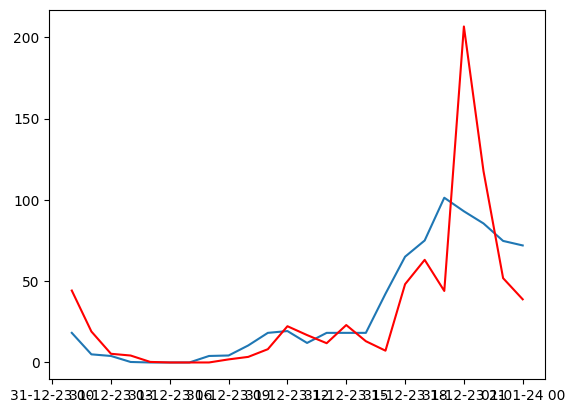

Train RMSE: 20.209
Test RMSE: 30.063


In [5]:
look_back = 36
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 2
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

# Remove duplicate indices
data_series = data_series[~data_series.index.duplicated(keep='first')]

train_predict, y_train, test_predict, y_test = lf.lstm_model(data_series, look_back, transforms, lstm_params)

C:\Users\tamas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


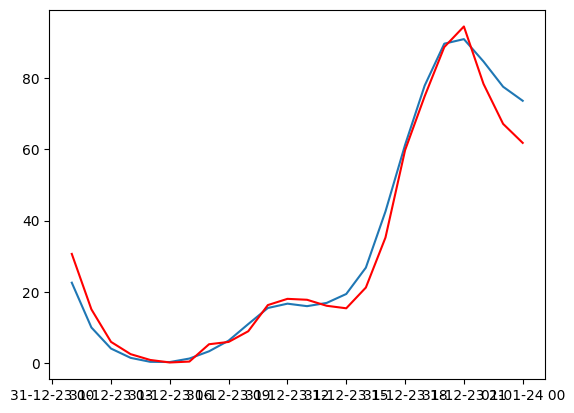

Train RMSE: 4.394
Test RMSE: 4.680


In [6]:
gaussian_filtering = pd.Series(gaussian_filter(data_series, sigma=1), index=data_series.index).astype(float)
# running LSTM with Gaussian-filtered data
look_back = 36
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 50
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lf.lstm_model(gaussian_filtering, look_back, transforms, lstm_params)